# Практический проект
Анализ активности студентов онлайн-курса
<a href='https://stepik.org/course/129/syllabus'> Введение в анализ данных в R </a>. 
-------------------------------------------------------
### Цель
Необходимо разработать модель машинного обучения, способную предсказать: закончит пользователь начатый курс или же не дойдет до конца

-------------------------------------------------------
### Описание данных
<b style='color:blue'>events_train.csv </b> - данные о действиях, которые совершают студенты со стэпами

 1. step_id - id стэпа
 2. user_id - анонимизированный id юзера
 3. timestamp - время наступления события в формате unix date
 4. action - событие, возможные значения: 
 - discovered - пользователь перешел на стэп
 - viewed - просмотр шага,
 - started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
 - passed - удачное решение практического шага

<b style='color:blue'> submissions_train.csv </b> - данные о времени и статусах сабмитов к практическим заданиям

1. step_id - id стэпа
2. timestamp - время отправки решения в формате unix date
3. submission_status - статус решения
4. user_id - анонимизированный id юзера
-------------------------------------------------------
### Вопросы и проблемы предметная область 
* Почему очень много пользователей записываются на онлайн-курсы, но так мало из них доходят до конца (около 5%)?
* Что можно сделать, чтобы улучшить метрику записавшихся/доходящих?
* Выявить на каких степах были проблемы у студентов; в какой момент они перестали учиться

Повышение проходимости курса не является самоцелью (этого легко добиться просто уменьшив объем курса), но интересно то, как можно повысить метрики качества в текущей ситуации (то есть не делая глобальных изменений)

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
matplotlib.rcParams['figure.figsize'] = [10, 5]

### Данные
1) Посмотреть на данные: о чем они рассказывают?  
2) Убедиться в их корректности


In [2]:
events_data = pd.read_csv('data/event_data_train.csv')
print('Число записей - ', len(events_data))
events_data.head(7)

Число записей -  3480703


,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632


In [6]:
submission_data = pd.read_csv('data/submissions_data_train.csv')
print('Число записей - ', len(submission_data))
submission_data.head(7)

Число записей -  509104


,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853
5,31976,1434348188,correct,15853
6,31976,1478852055,correct,15853


### Первичное преобразование и представление данных

In [7]:
events_data['timestamp'] = pd.to_datetime(events_data['timestamp'], unit='s')
submission_data['timestamp'] = pd.to_datetime(submission_data['timestamp'], unit='s')


# первые действия на курсе
events_data.head(3)

,step_id,timestamp,action,user_id
0,32815,2015-06-15 04:00:48,viewed,17632
1,32815,2015-06-15 04:00:48,passed,17632
2,32815,2015-06-15 04:00:48,discovered,17632


#### Какой период времени охватывают данные?

In [8]:
# данные о действиях
(events_data['timestamp'].max() - events_data['timestamp'].min())

Timedelta('1069 days 19:32:43')

In [9]:
# данные о сабмитах
(submission_data['timestamp'].max() - submission_data['timestamp'].min())

Timedelta('1069 days 19:04:43')

####  Добавление колонок с датой формата год-месяц-день

In [10]:
# данные о действиях
events_data['date'] = events_data.timestamp.dt.date
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,2015-06-15 04:00:48,viewed,17632,2015-06-15
1,32815,2015-06-15 04:00:48,passed,17632,2015-06-15
2,32815,2015-06-15 04:00:48,discovered,17632,2015-06-15
3,32811,2015-06-15 04:01:35,discovered,17632,2015-06-15
4,32811,2015-06-15 04:01:35,viewed,17632,2015-06-15


In [11]:
# данные о сабмитах
submission_data['date'] = submission_data.timestamp.dt.date
submission_data.head()

,step_id,timestamp,submission_status,user_id,date
0,31971,2015-06-15 06:21:15,correct,15853,2015-06-15
1,31972,2015-06-15 06:05:00,correct,15853,2015-06-15
2,31972,2016-11-11 08:15:49,wrong,15853,2016-11-11
3,31972,2016-11-11 08:16:04,correct,15853,2016-11-11
4,31976,2015-06-15 06:02:03,wrong,15853,2015-06-15


#### Cколько уникальных пользователей по каждому дню?

In [49]:
# данные о действиях
events_data.groupby('date')['user_id'].nunique().head()

date
2015-06-15    705
2015-06-16    526
2015-06-17    440
2015-06-18    411
2015-06-19    377
Name: user_id, dtype: int64

Text(0, 0.5, 'число уникальных users')

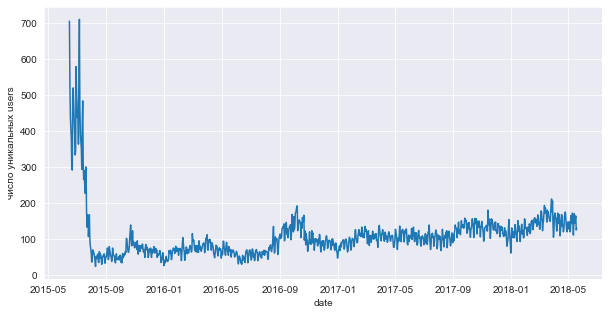

In [78]:
events_data.groupby('date')['user_id'].nunique().plot()
plt.ylabel('число уникальных users')

Как мы видим, наибольший наплыв людей происходил в начале курса (как раз тогда, когда были дедлайны). Затем наблюдается спад активности.

#### Как распределены пользователи по количеству баллов за курс ?

In [71]:
# данные о действиях
events_data[events_data['action']=='passed'].groupby('user_id', as_index=False) \
                                            .agg({'step_id':'count'}) \
                                            .rename(columns={'step_id':'count of passed'}) \
                                            .head()

,user_id,count of passed
0,2,9
1,3,87
2,5,11
3,7,1
4,8,84


Text(0, 0.5, 'количество студентов')

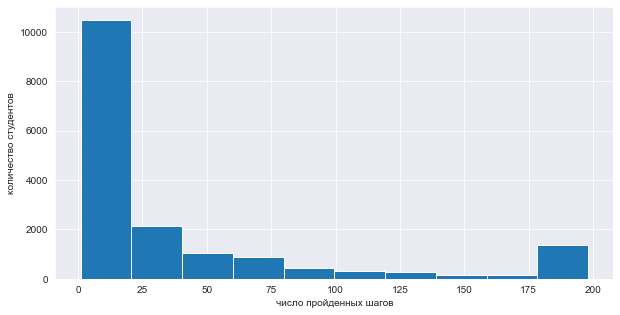

In [77]:
events_data[events_data['action']=='passed'].groupby('user_id', as_index=False) \
                                            .agg({'step_id':'count'}) \
                                            .rename(columns={'step_id':'count of passed'}) \
                                            ['count of passed'].hist()
plt.xlabel('число пройденных шагов')
plt.ylabel('количество студентов')

Как мы видим, число студентов падает с ростом числа пройденных степов. Это подтверждает (в некотором смысле) гипотезу о том, что студенты редко доходят до конца курса

**Ошибка**, которую мы совершили: не учли студентов, у которых нет пройденных шагов вообще

In [82]:
events_data[events_data['action']=='passed'].groupby('user_id', as_index=False) \
                                            .agg({'step_id':'count'}) \
                                            .rename(columns={'step_id':'count of passed'}).min()

user_id            2
count of passed    1
dtype: int64

In [12]:
# для решения воспользуемся pivot_table
pv1 = events_data.pivot_table(index='user_id', columns=['action'], values='step_id',
                             aggfunc='count', fill_value=0).reset_index()
pv1.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


Text(0, 0.5, 'количество студентов')

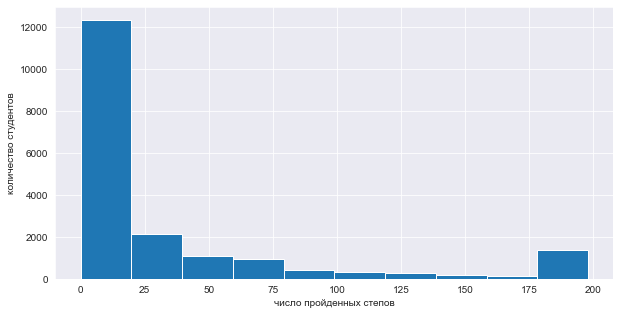

In [93]:
# корректное решение
pv1.passed.hist()
plt.xlabel('число пройденных степов')
plt.ylabel('количество студентов')

На самом деле, можно было решить ту же задачу (посмотреть на распределение решенных заданий) с использованием другого набора данных

In [13]:
pv2 = submission_data.pivot_table(index='user_id', columns=['submission_status'], values='step_id',
                                 aggfunc='count', fill_value=0).reset_index()
pv2.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


Text(0, 0.5, 'количество студентов')

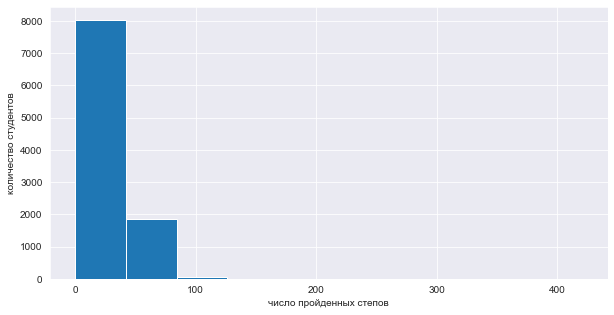

In [10]:
pv2.correct.hist()
plt.xlabel('число пройденных степов')
plt.ylabel('количество студентов')

### Feature engineering
*Уникальные степы, пройденные пользователем; количество дней, которые пользователь учился на платформе; количество решенных/нерешенных задач* - все это можно представить как признаки для задачи машинного обучения. Сравним эти показатели для людей, которые успешно прошли курс, и людей, которые не дошли до конца


**Одна из главных текущих задач** - это *разметка* имеющихся данных. Мы видим, что в исходных данных нет информации о том, ушел пользователь или нет. Но мы можем распознать пользователей, которые набрали нужное число баллов для получения сертификата. Кроме того, нужно ответить на вопрос: какого пользователя можно считать *покинувшим курс*? Можно анализировать время последних действий, но эта эвристика должна быть обоснована (некоторые покидают курс на 2 недели, потом вновь возвращаются - следует провести глубокий анализ)

Один из подходов к решению: посмотреть на периодичность действий на курсе для каждого пользователя, затем сагрегировать информацию о всех пользователях и сделать выводы (*какой период отсутствия будет пороговым для того, чтобы считать пользователя покинувшим курс?*)

In [14]:
# отберем нужные колонки
# произведем группировку по юзеру и дате (день-месяц-год)
data_for_analysis = events_data[['user_id', 'date', 'timestamp']].drop_duplicates(subset=['user_id', 'date'])
data_for_analysis.head()

,user_id,date,timestamp
0,17632,2015-06-15,2015-06-15 04:00:48
36,12494,2015-06-15,2015-06-15 04:18:51
59,442,2015-06-15,2015-06-15 04:20:29
62,22254,2015-06-15,2015-06-15 04:20:42
94,6646,2015-06-15,2015-06-15 04:23:50


In [15]:
# соберем все timestamps для каждого пользователя
data_for_analysis.groupby('user_id')['timestamp'].apply(list).head()

user_id
1                                [2016-09-02 14:44:24]
2           [2017-12-27 14:02:44, 2018-02-21 15:29:26]
3    [2015-06-15 08:54:36, 2015-09-03 05:22:05, 201...
5           [2016-06-17 09:46:49, 2017-07-12 11:40:21]
7                                [2018-03-21 12:17:40]
Name: timestamp, dtype: object

In [18]:
# разница между timestamps для каждого пользователя
data_for_analysis.groupby('user_id')['timestamp'].apply(list).apply(np.diff).head()

user_id
1                                                   []
2                                   [56 days 01:26:42]
3    [79 days 20:27:29, 2 days 02:41:24, 1 days 02:...
5                                  [390 days 01:53:32]
7                                                   []
Name: timestamp, dtype: object

In [16]:
# массив массивов
periods_of_time = data_for_analysis.groupby('user_id')['timestamp'].apply(list).apply(np.diff).values
# перевод в один массив и далее в pd.Series
periods_of_time = pd.Series(np.concatenate(periods_of_time, axis=0))

Text(0.5, 0, 'Число студентов с такой периодичностью')

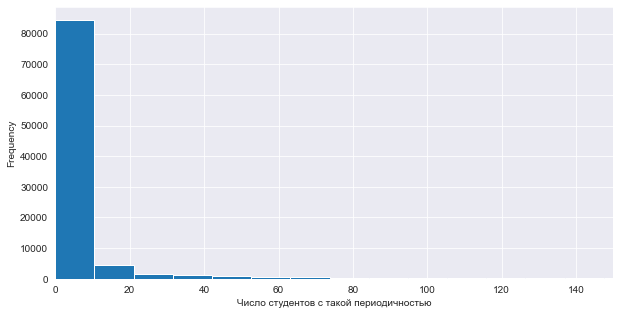

In [34]:
periods_of_time.dt.days.plot.hist(bins=100)
plt.xlim([0, 150])
plt.xlabel('Число дней между действиями')
plt.xlabel('Число студентов с такой периодичностью')

Обратим внимание, что в основном периодичность между действиями студентов не превышает 25 дней

In [15]:
periods_of_time.quantile(0.93)

Timedelta('34 days 18:29:10.279999999')

93% пользователей укладываются в периодичность в 34 дня (~ месяц)

Итак, для разметки будем использовать следующие условия:
- студент не получил сертификат (число правильно решенных заданий < 60)
- студент отсутствует больше ~34 дня (то есть разница между датой последнего действия на курсе и датой последнего действия пользователя на курсе превышает ~34 дня)

При этих двух условиях можно считать, что пользователь покинул курс

#### Разметка

In [9]:
# дата последнего действия каждого пользователя
events_data.groupby('user_id', as_index=False).agg({'timestamp': 'max'}).head()

,user_id,timestamp
0,1,2016-09-02 14:44:24
1,2,2018-02-21 15:29:26
2,3,2015-10-11 16:39:48
3,5,2017-07-12 11:45:39
4,7,2018-03-21 12:17:40


In [10]:
# дата последнего действия на курсе
events_data.timestamp.max()

Timestamp('2018-05-19 23:33:31')

In [17]:
last_date = events_data.timestamp.max()
temp_df = events_data.groupby('user_id', as_index=False).agg({'timestamp': 'max'}) \
                                                        .rename(columns={'timestamp':'last_timestamp'})
constraint = periods_of_time.quantile(0.93)
temp_df['critical time of absence'] = (last_date - temp_df['last_timestamp']) > constraint
temp_df.head()

,user_id,last_timestamp,critical time of absence
0,1,2016-09-02 14:44:24,True
1,2,2018-02-21 15:29:26,True
2,3,2015-10-11 16:39:48,True
3,5,2017-07-12 11:45:39,True
4,7,2018-03-21 12:17:40,True


In [20]:
# добавим информацию о баллах за курс
pv2.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [18]:
# outer, чтобы сохранить информацию о пользователях, не делающих никаких сабмитов
result_df = temp_df.merge(pv2, on='user_id', how='outer')
result_df.head()

,user_id,last_timestamp,critical time of absence,correct,wrong
0,1,2016-09-02 14:44:24,True,NaN,NaN
1,2,2018-02-21 15:29:26,True,2.0,0.0
2,3,2015-10-11 16:39:48,True,29.0,23.0
3,5,2017-07-12 11:45:39,True,2.0,2.0
4,7,2018-03-21 12:17:40,True,NaN,NaN


In [19]:
result_df.fillna(0, inplace=True)
result_df['complete course'] = result_df.correct >= 60
result_df.head()

,user_id,last_timestamp,critical time of absence,correct,wrong,complete course
0,1,2016-09-02 14:44:24,True,0.0,0.0,False
1,2,2018-02-21 15:29:26,True,2.0,0.0,False
2,3,2015-10-11 16:39:48,True,29.0,23.0,False
3,5,2017-07-12 11:45:39,True,2.0,2.0,False
4,7,2018-03-21 12:17:40,True,0.0,0.0,False


#### Соединение всех таблиц для обогащения набора данных

In [54]:
# данные о действиях
pv1.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [20]:
result_df = result_df.merge(pv1, on='user_id', how='outer')
result_df.head()

,user_id,last_timestamp,critical time of absence,correct,wrong,complete course,discovered,passed,started_attempt,viewed
0,1,2016-09-02 14:44:24,True,0.0,0.0,False,1,0,0,1
1,2,2018-02-21 15:29:26,True,2.0,0.0,False,9,9,2,10
2,3,2015-10-11 16:39:48,True,29.0,23.0,False,91,87,30,192
3,5,2017-07-12 11:45:39,True,2.0,2.0,False,11,11,4,12
4,7,2018-03-21 12:17:40,True,0.0,0.0,False,1,1,0,1


In [56]:
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,2015-06-15 04:00:48,viewed,17632,2015-06-15
1,32815,2015-06-15 04:00:48,passed,17632,2015-06-15
2,32815,2015-06-15 04:00:48,discovered,17632,2015-06-15
3,32811,2015-06-15 04:01:35,discovered,17632,2015-06-15
4,32811,2015-06-15 04:01:35,viewed,17632,2015-06-15


In [21]:
# число уникальных дней, проведенных на курсе
events_data.groupby('user_id', as_index=False)['date'].nunique()\
                        .rename(columns={'date': 'number of days'})

,user_id,number of days
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1
...,...,...
19229,26790,4
19230,26793,1
19231,26794,9
19232,26797,2


In [22]:
result_df = result_df.merge(events_data.groupby('user_id', as_index=False)['date'].nunique()\
                        .rename(columns={'date': 'number of days'}),
                on='user_id', how='outer')
result_df.head()

,user_id,last_timestamp,critical time of absence,correct,wrong,complete course,discovered,passed,started_attempt,viewed,number of days
0,1,2016-09-02 14:44:24,True,0.0,0.0,False,1,0,0,1,1
1,2,2018-02-21 15:29:26,True,2.0,0.0,False,9,9,2,10,2
2,3,2015-10-11 16:39:48,True,29.0,23.0,False,91,87,30,192,7
3,5,2017-07-12 11:45:39,True,2.0,2.0,False,11,11,4,12,2
4,7,2018-03-21 12:17:40,True,0.0,0.0,False,1,1,0,1,1


In [59]:
result_df.to_csv('data/result_dataset.csv')

Наша цель - как можно раньше предсказать уход студента с курса. То есть, нам нужно по имеющейся на **текущей** момент информации предсказать об уходе студента (например, у нас будут данные, скопленные за первые 5 дней с начала курса; можно ли по этим данным получить прогноз?). Таким образом, все признаки в имеющемся датасете (`result_dataset`) нужны для разметки нашего набора, а вот признаки в начальный момент (их ещё нужно сделать) нужны для предсказания ухода. 

**Задача**: по поведению пользователя за первые N дней предсказать - уйдет студент с курса или пройдет его успешно

In [24]:
df = pd.read_csv('data/result_dataset.csv', index_col=0)
df.head()

,user_id,last_timestamp,critical time of absence,correct,wrong,complete course,discovered,passed,started_attempt,viewed,number of days
0,1,2016-09-02 14:44:24,True,0.0,0.0,False,1,0,0,1,1
1,2,2018-02-21 15:29:26,True,2.0,0.0,False,9,9,2,10,2
2,3,2015-10-11 16:39:48,True,29.0,23.0,False,91,87,30,192,7
3,5,2017-07-12 11:45:39,True,2.0,2.0,False,11,11,4,12,2
4,7,2018-03-21 12:17:40,True,0.0,0.0,False,1,1,0,1,1


# Задача 1:  нахождение автора курса
Автор курса, вероятно, должен отличаться от других хотя бы одной статистикой. Посмотрим на количество решенных заданий для пользователя, отсортируем в порядке убывания

In [41]:
correct_submission = submission_data[submission_data['submission_status']=='correct']
correct_submission.head()

,step_id,timestamp,submission_status,user_id,date
0,31971,2015-06-15 06:21:15,correct,15853,2015-06-15
1,31972,2015-06-15 06:05:00,correct,15853,2015-06-15
3,31972,2016-11-11 08:16:04,correct,15853,2016-11-11
5,31976,2015-06-15 06:03:08,correct,15853,2015-06-15
6,31976,2016-11-11 08:14:15,correct,15853,2016-11-11


In [48]:
correct_submission.groupby(['user_id'])['date'].agg('count').sort_values(ascending=False)

user_id
1046     421
5552     186
17135    168
6183     142
8461     135
        ... 
6191       1
6184       1
6166       1
15771      1
20633      1
Name: date, Length: 9794, dtype: int64

Как мы видим, один из пользователей явно отличается от других по числу пройденных степов. Посмотрим на количество действий этого пользователя

In [49]:
events_data[events_data['user_id']==1046]

,step_id,timestamp,action,user_id,date
3303,32815,2015-06-15 06:58:39,viewed,1046,2015-06-15
3316,32979,2015-06-15 06:58:57,viewed,1046,2015-06-15
3350,32979,2015-06-15 06:59:41,viewed,1046,2015-06-15
3354,32979,2015-06-15 06:59:56,viewed,1046,2015-06-15
3363,32979,2015-06-15 07:00:09,viewed,1046,2015-06-15
...,...,...,...,...,...
3143027,32927,2018-03-08 11:33:39,viewed,1046,2018-03-08
3205063,33489,2018-03-19 09:31:15,viewed,1046,2018-03-19
3400569,32198,2018-04-29 14:10:09,viewed,1046,2018-04-29
3408695,32173,2018-05-01 07:47:37,viewed,1046,2018-05-01


In [51]:
events_data.groupby('user_id')['date'].agg('count').sort_values(ascending=False)

user_id
20907    33043
10794    16436
25279    10179
1046      9095
3572      7905
         ...  
19546        2
1            2
11437        1
8773         1
26502        1
Name: date, Length: 19234, dtype: int64